In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='/content/drive/My Drive/autoencoder/data', train=True, download=True, transform=transform)

data_loader = torch.utils.data.DataLoader(dataset=mnist_data,
                                          batch_size=64,
                                          shuffle=True)

mnist_data_valid = datasets.MNIST(root='/content/drive/My Drive/autoencoder/data', train=False, download=True, transform=transform)

data_loader_valid = torch.utils.data.DataLoader(dataset=mnist_data_valid,
                                          batch_size=64,
                                          shuffle=True)

In [ ]:
dataiter = iter(data_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [ ]:
# repeatedly reduce the size
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3) # -> N, 3
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Input [-1, +1] -> use nn.Tanh

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )

        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

class Autoencoder2(nn.Module):
    def __init__(self):
        super().__init__()
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            nn.Tanh(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            nn.Tanh(),
            nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )

        # N , 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            nn.Tanh(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            nn.Tanh(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

class Autoencoder3(nn.Module):
    def __init__(self):
        super().__init__()
        # Codificador
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=True)

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # -> N, 16, 14, 14
            nn.ReLU(),
            self.pool1,                               # -> N, 16, 7, 7
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # -> N, 32, 4, 4
            nn.ReLU(),
            self.pool2,                               # -> N, 32, 2, 2
            nn.Conv2d(32, 64, 2)                      # -> N, 64, 1, 1
        )

        # Decodificador
        self.unpool2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.unpool1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2),            # -> N, 32, 2, 2
            self.unpool2,                             # -> N, 32, 4, 4
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # -> N, 16, 7, 7
            self.unpool1,                             # -> N, 16, 14, 14
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # -> N, 1, 28, 28
            nn.Sigmoid()
        )

    def forward(self, x):
        # Codificación con índices
        x = self.encoder[0](x)  # Conv2D
        x = self.encoder[1](x)  # ReLU
        x, idx1 = self.pool1(x)  # MaxPool2D con índices
        x = self.encoder[3](x)  # Conv2D
        x = self.encoder[4](x)  # ReLU
        x, idx2 = self.pool2(x)  # MaxPool2D con índices
        x = self.encoder[6](x)  # Conv2D final

        # Decodificación usando los índices
        x = self.decoder[0](x)  # ConvTranspose2D
        x = self.unpool2(x, idx2)  # MaxUnpool2D
        x = self.decoder[2](x)  # ConvTranspose2D
        x = self.unpool1(x, idx1)  # MaxUnpool2D
        x = self.decoder[4](x)  # ConvTranspose2D final
        return x



# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh



class ImprovedAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # -> N, 16, 14, 14
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # -> N, 32, 7, 7
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 128, 7)  # -> N, 128, 1, 1
        )
        self.encoder_fc = nn.Sequential(
            nn.Flatten(),  # Flatten -> N, 128
            nn.Linear(128, 32)  # Bottleneck -> N, 32
        )

        # Decoder
        self.decoder_fc = nn.Sequential(
            nn.Linear(32, 128),  # Expand -> N, 128
            nn.Unflatten(1, (128, 1, 1))  # Reshape to 2D -> N, 128, 1, 1
        )
        self.decoder_cnn = nn.Sequential(
            nn.ConvTranspose2d(128, 32, 7),  # -> N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # -> N, 16, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  # -> N, 1, 28, 28
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encoding
        encoded = self.encoder_cnn(x)
        encoded = self.encoder_fc(encoded)
        # Decoding
        decoded = self.decoder_fc(encoded)
        decoded = self.decoder_cnn(decoded)
        return decoded



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = Autoencoder().to(device)
#model = Autoencoder_Linear()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=1e-5)

In [ ]:
# Point to training loop video
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img = img.to(device)
        #img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        recon = model(img)
        loss = criterion(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img.cpu(), recon.cpu()))

Epoch:1, Loss:0.0085
Epoch:2, Loss:0.0047
Epoch:3, Loss:0.0037
Epoch:4, Loss:0.0031
Epoch:5, Loss:0.0036
Epoch:6, Loss:0.0030
Epoch:7, Loss:0.0033
Epoch:8, Loss:0.0030
Epoch:9, Loss:0.0029
Epoch:10, Loss:0.0030


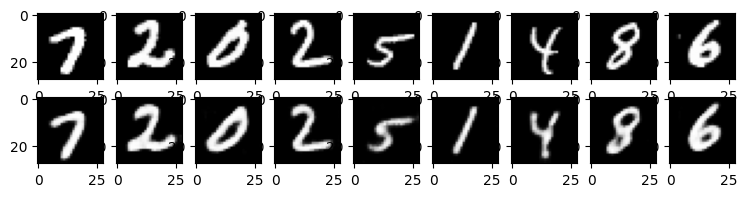

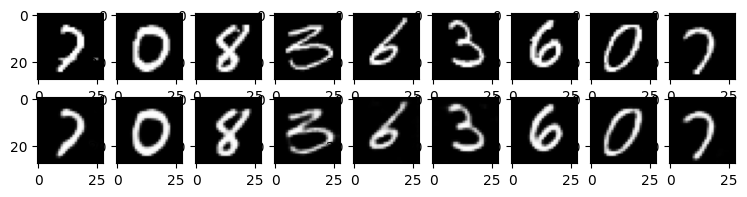

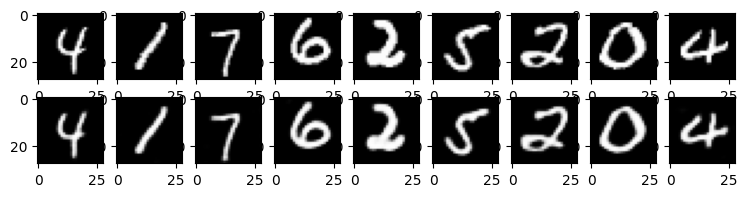

In [ ]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        #item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        #item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])

## Pruebas sobre el conjunto de validación

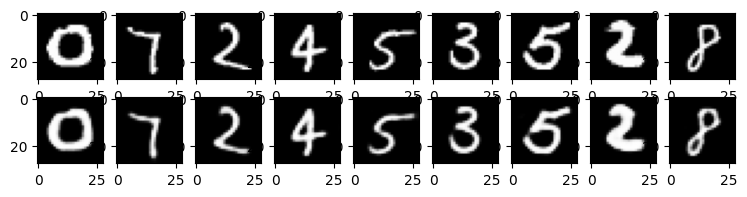

In [ ]:
model.eval()

dataiter = iter(data_loader_valid)
images, labels = next(dataiter)

# Transfiere imágenes al dispositivo
images = images.to(device)

plt.figure(figsize=(9, 2))
plt.gray()

for i, img in enumerate(images[:9]):
    with torch.no_grad():
        # Asegúrate de que la imagen esté en la GPU
        img = img.unsqueeze(0)  # Añade dimensión para el batch (N=1)
        img = img.to(device)

        # Predicción con el modelo
        pred = model(img)

        # Reconstrucción
        recon = pred[0].cpu().detach().numpy().squeeze()  # Mueve la salida de vuelta a la CPU y elimina dimensión extra

        # Visualización
        plt.subplot(2, 9, i+1)
        plt.imshow(img[0].cpu().numpy().squeeze())  # Original en CPU para visualización

        plt.subplot(2, 9, i+1+9)
        plt.imshow(recon)  # Reconstrucción


### Ejercicios

- Crea un supresor de ruido de imágenes. Añade ruido a las imágenes de entrada y compáralas a la salida con las originales. Varía los hiperparámetros y busca el mejor supresor.



In [ ]:
def add_noise(images, noise_factor=0.5):
    noisy_images = images + noise_factor * torch.randn_like(images).to(images.device)
    noisy_images = torch.clamp(noisy_images, 0., 1.)
    return noisy_images

Buscamos los mejores hiperparámetros para 10 épocas:

In [ ]:
from itertools import product

# Verificar si GPU está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definir los hiperparámetros a explorar
learning_rates = [1e-2, 1e-3, 1e-4]
noise_factors = [0.5, 0.7, 0.9]
weight_decays = [1e-5, 1e-4, 1e-3]
num_epochs = 10

# Función para agregar ruido
def add_noise(img, noise_factor=0.5):
    noise = torch.randn_like(img) * noise_factor
    noisy_img = img + noise
    return torch.clamp(noisy_img, 0., 1.)  # Asegurar que los valores estén entre 0 y 1

# Guardar resultados
results = []

# Búsqueda en el espacio de hiperparámetros
for lr, noise_factor, wd in product(learning_rates, noise_factors, weight_decays):
    print(f"Training with lr={lr}, noise_factor={noise_factor}, weight_decay={wd}")

    # Crear modelo y moverlo a la GPU
    model = Autoencoder().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    # Entrenamiento
    for epoch in range(num_epochs):
        epoch_loss = 0
        for (img, _) in data_loader:
            img = img.to(device)  # Mover imágenes a la GPU
            noisy_image = add_noise(img, noise_factor=noise_factor)  # Agregar ruido
            noisy_image = noisy_image.to(device)  # Asegurar que las imágenes ruidosas también estén en GPU

            recon = model(noisy_image)  # Reconstrucción
            loss = criterion(recon, img)  # Cálculo de la pérdida

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        epoch_loss /= len(data_loader)  # Promedio por batch
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Guardar el resultado final
    results.append({
        "lr": lr,
        "noise_factor": noise_factor,
        "weight_decay": wd,
        "final_loss": epoch_loss
    })

# Ordenar los resultados por la menor pérdida final
best_params = sorted(results, key=lambda x: x['final_loss'])[0]
print(f"Best Parameters: {best_params}")


Training with lr=0.01, noise_factor=0.5, weight_decay=1e-05
Epoch 1/10, Loss: 0.0484
Epoch 2/10, Loss: 0.0163
Epoch 3/10, Loss: 0.0149
Epoch 4/10, Loss: 0.0146
Epoch 5/10, Loss: 0.0144
Epoch 6/10, Loss: 0.0143
Epoch 7/10, Loss: 0.0142
Epoch 8/10, Loss: 0.0142
Epoch 9/10, Loss: 0.0142
Epoch 10/10, Loss: 0.0142
Training with lr=0.01, noise_factor=0.5, weight_decay=0.0001
Epoch 1/10, Loss: 0.0256
Epoch 2/10, Loss: 0.0182
Epoch 3/10, Loss: 0.0180
Epoch 4/10, Loss: 0.0178
Epoch 5/10, Loss: 0.0178
Epoch 6/10, Loss: 0.0177
Epoch 7/10, Loss: 0.0177
Epoch 8/10, Loss: 0.0177
Epoch 9/10, Loss: 0.0176
Epoch 10/10, Loss: 0.0176
Training with lr=0.01, noise_factor=0.5, weight_decay=0.001
Epoch 1/10, Loss: 0.0696
Epoch 2/10, Loss: 0.0679
Epoch 3/10, Loss: 0.0640
Epoch 4/10, Loss: 0.0341
Epoch 5/10, Loss: 0.0328
Epoch 6/10, Loss: 0.0326
Epoch 7/10, Loss: 0.0325
Epoch 8/10, Loss: 0.0325
Epoch 9/10, Loss: 0.0324
Epoch 10/10, Loss: 0.0323
Training with lr=0.01, noise_factor=0.7, weight_decay=1e-05
Epoch 

In [ ]:
# Crear un diccionario para almacenar los mejores resultados por noise_factor
best_params_per_noise = {}

# Agrupar los resultados por noise_factor
for noise_factor in set([res["noise_factor"] for res in results]):
    # Filtrar resultados para este noise_factor
    noise_results = [res for res in results if res["noise_factor"] == noise_factor]
    # Ordenar por final_loss y tomar el mejor
    best_params = sorted(noise_results, key=lambda x: x["final_loss"])[0]
    best_params_per_noise[noise_factor] = best_params

# Mostrar los mejores resultados por noise_factor
for noise_factor, params in best_params_per_noise.items():
    print(f"Noise Factor: {noise_factor}, Best Params: {params}")


Noise Factor: 0.5, Best Params: {'lr': 0.001, 'noise_factor': 0.5, 'weight_decay': 1e-05, 'final_loss': 0.011425378001622681}
Noise Factor: 0.7, Best Params: {'lr': 0.001, 'noise_factor': 0.7, 'weight_decay': 1e-05, 'final_loss': 0.01776476966828775}
Noise Factor: 0.9, Best Params: {'lr': 0.001, 'noise_factor': 0.9, 'weight_decay': 1e-05, 'final_loss': 0.02454052723126053}


Entonces, tomamos como mejores hiperparámetros lr=0.001 y weight_decay= 1e-05

Training with lr=0.001, noise_factor=0.5, weight_decay=1e-05
Epoch 1/10, Loss: 0.0389


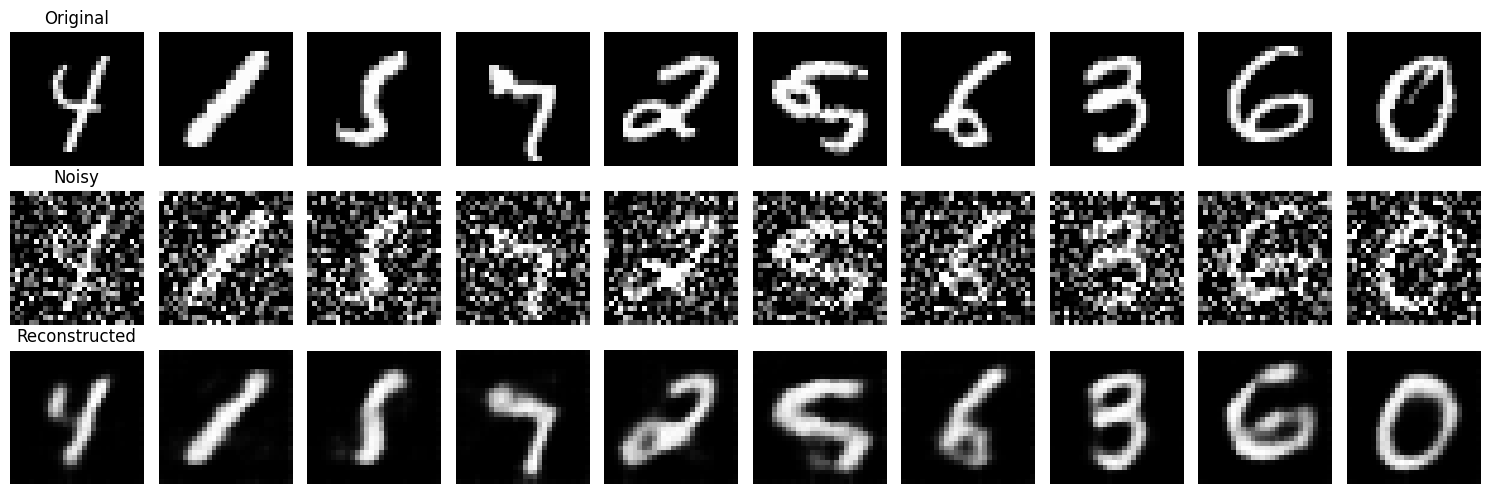

Epoch 2/10, Loss: 0.0161


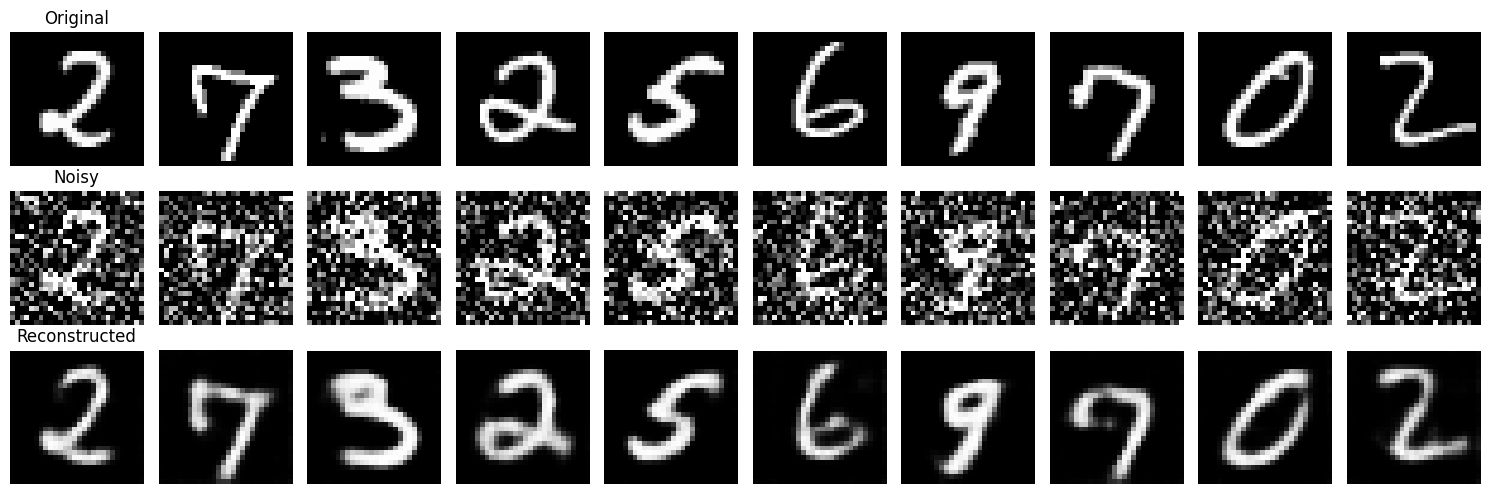

Epoch 3/10, Loss: 0.0137


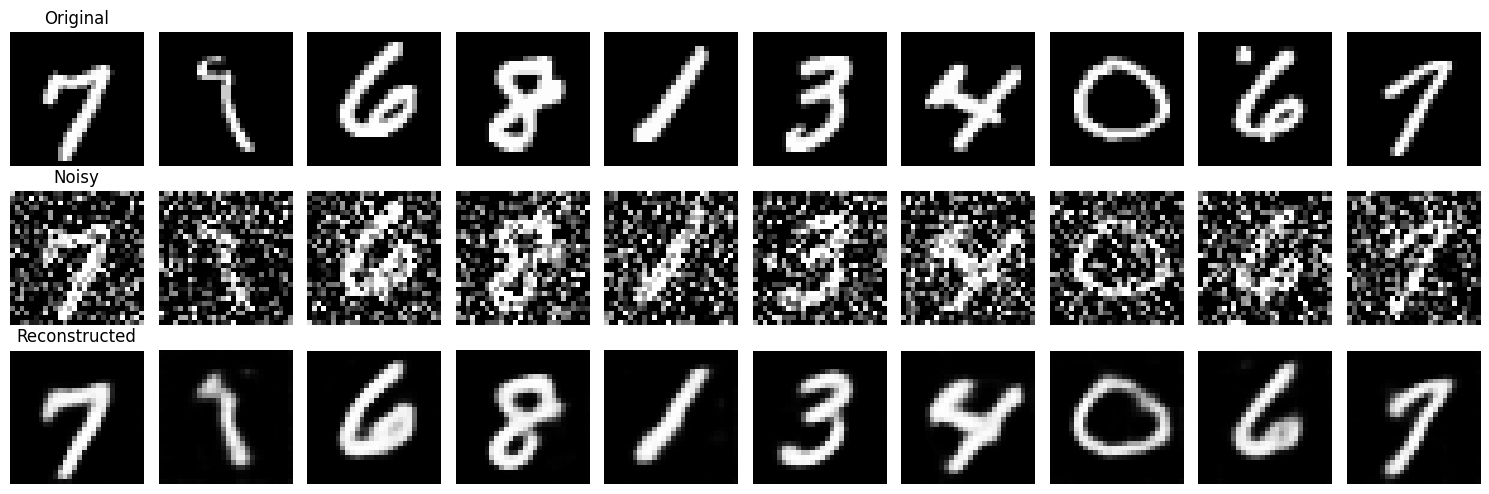

Epoch 4/10, Loss: 0.0126


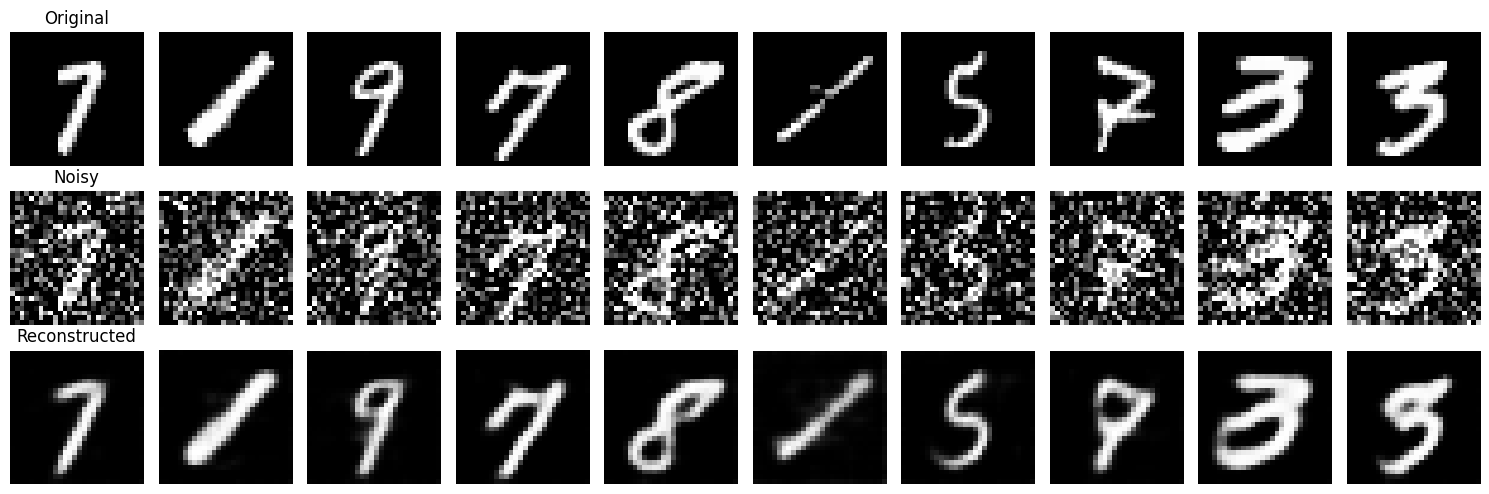

Epoch 5/10, Loss: 0.0121


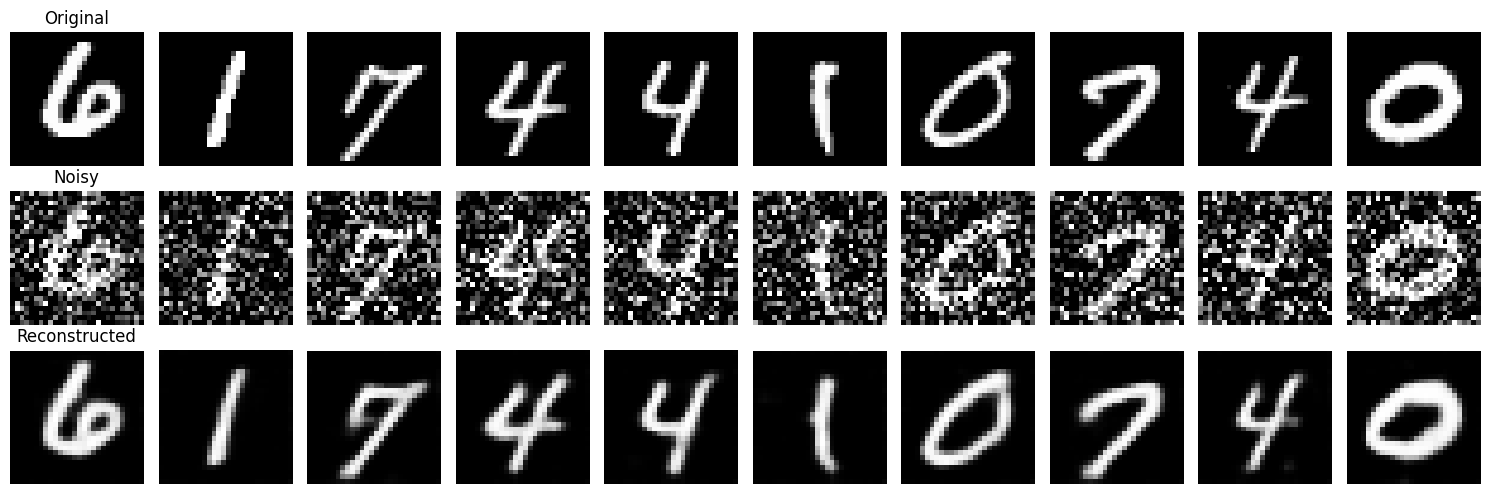

Epoch 6/10, Loss: 0.0118


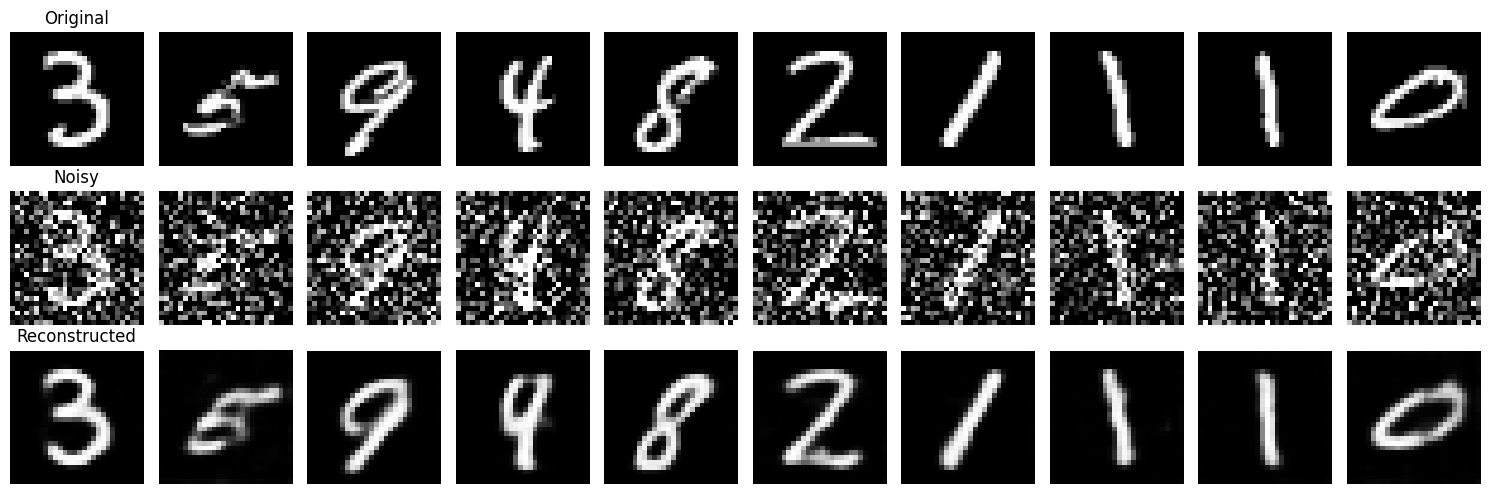

Epoch 7/10, Loss: 0.0116


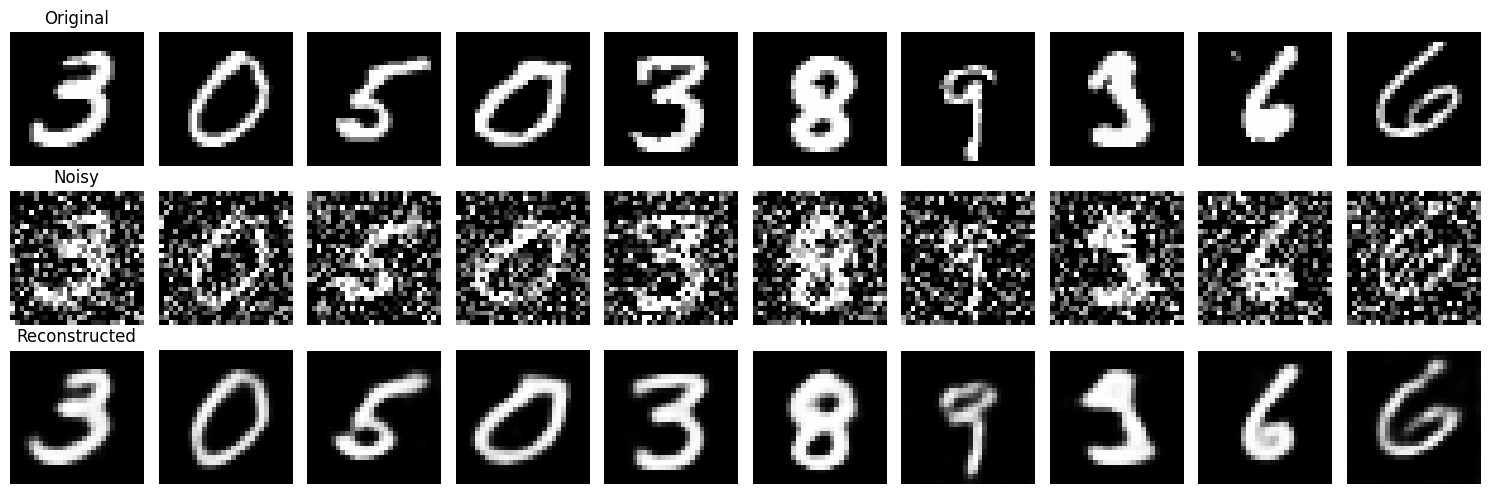

Epoch 8/10, Loss: 0.0114


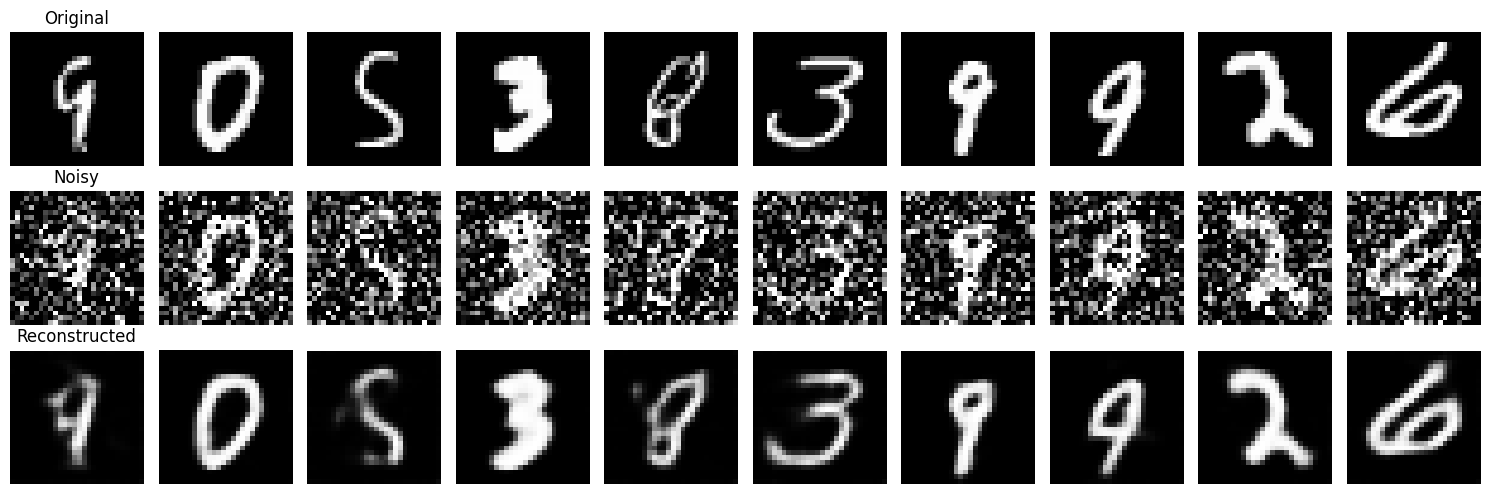

Epoch 9/10, Loss: 0.0114


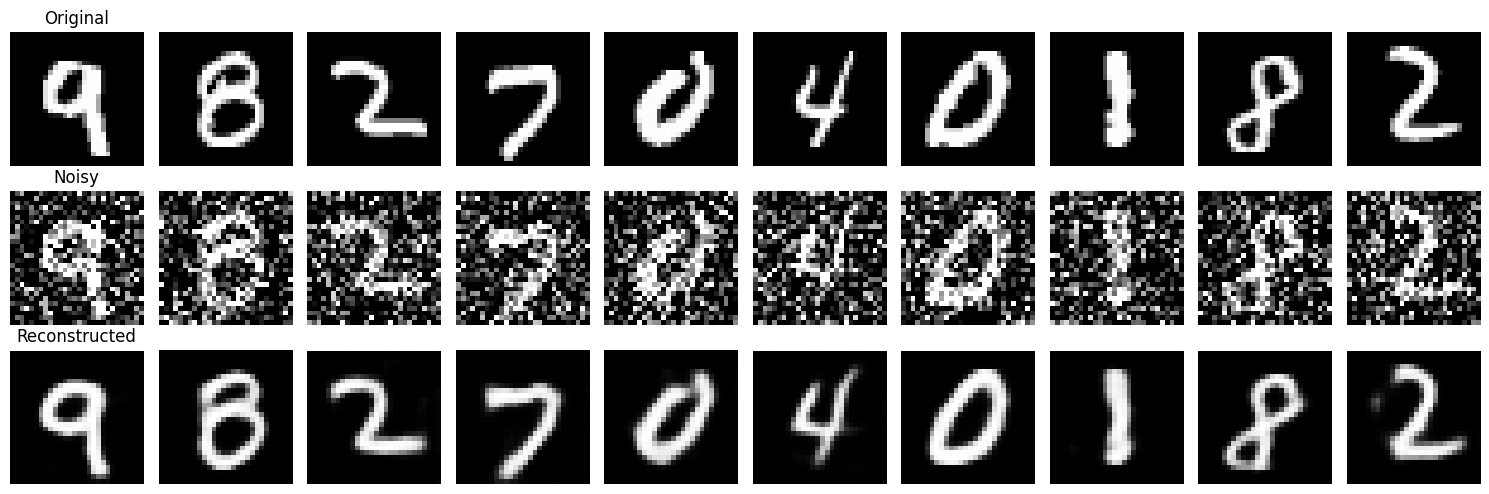

Epoch 10/10, Loss: 0.0113


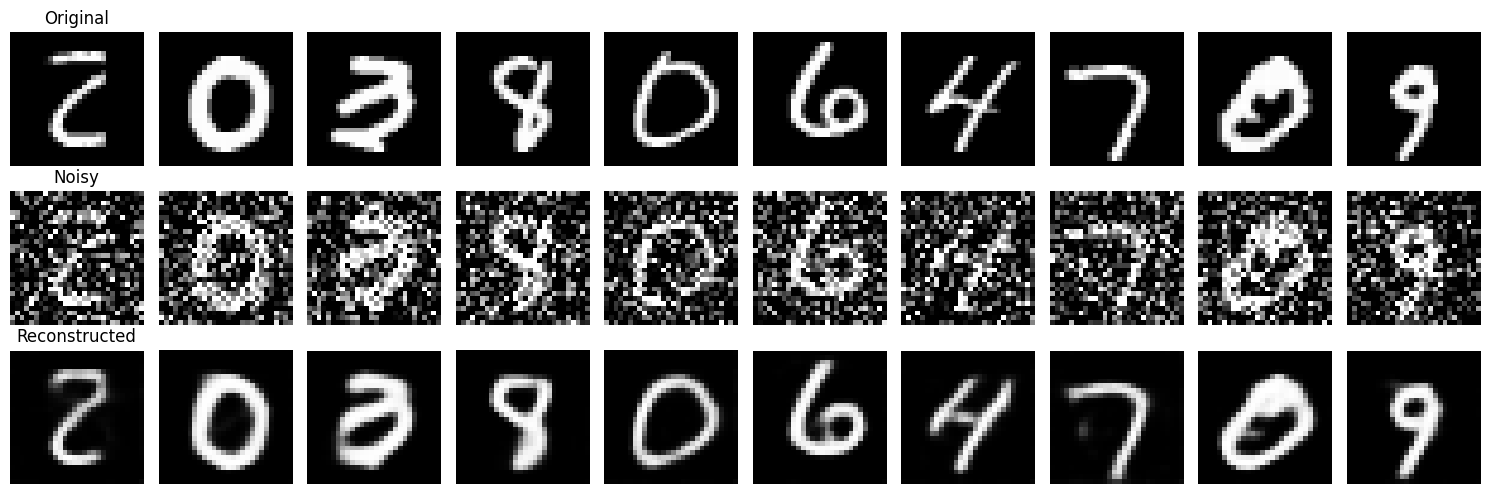

Training with lr=0.001, noise_factor=0.7, weight_decay=1e-05
Epoch 1/10, Loss: 0.0506


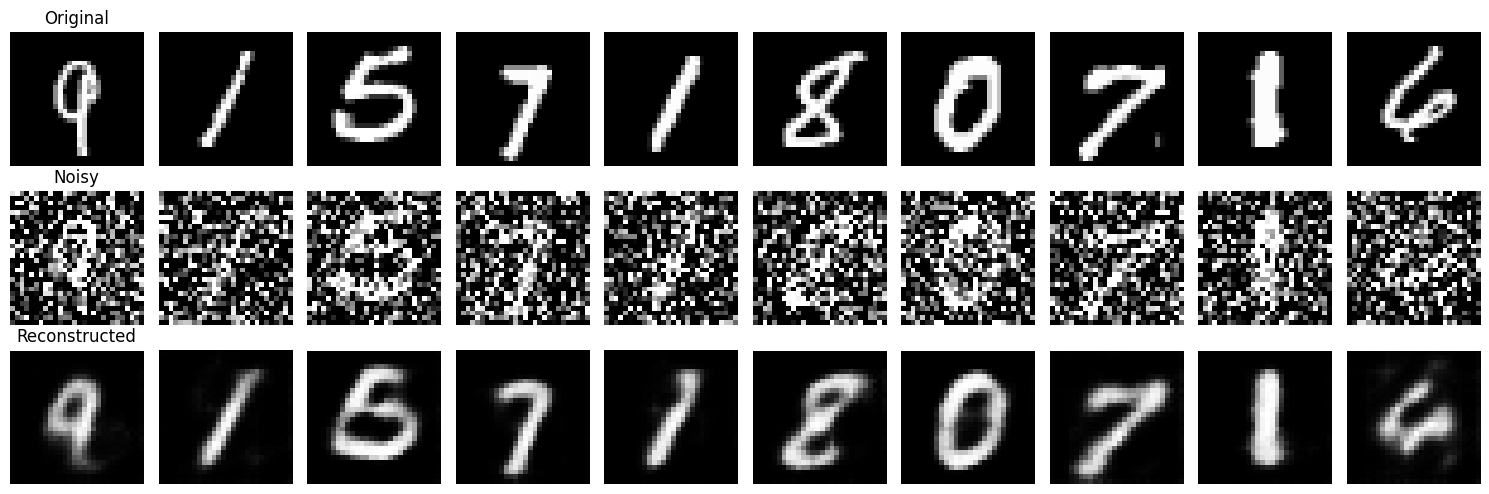

Epoch 2/10, Loss: 0.0231


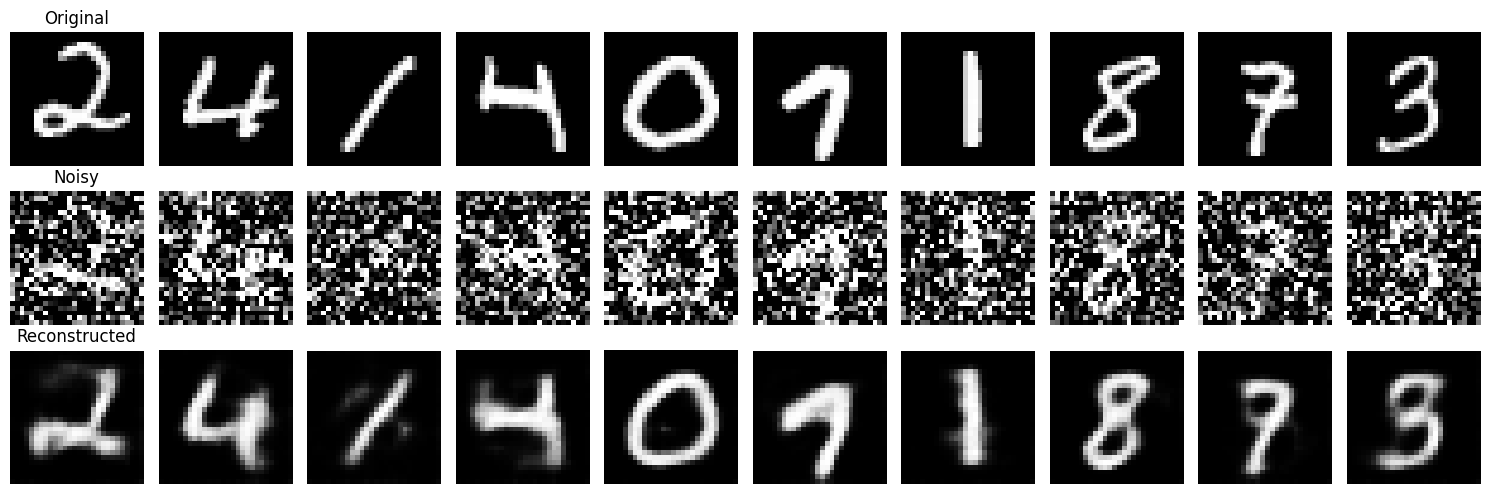

Epoch 3/10, Loss: 0.0202


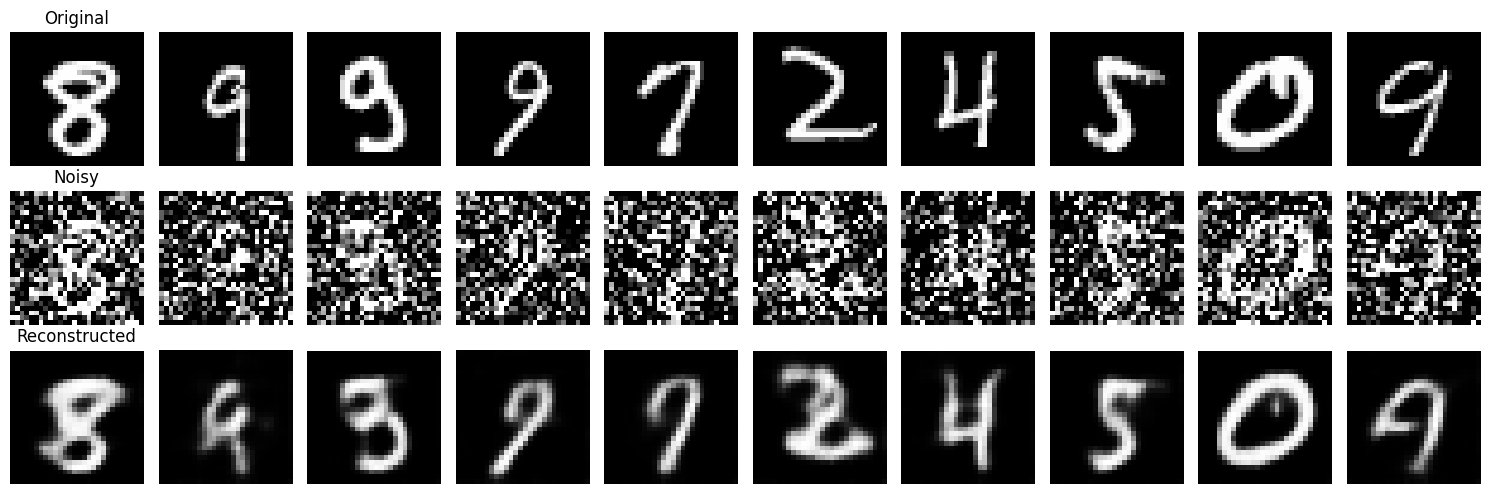

Epoch 4/10, Loss: 0.0191


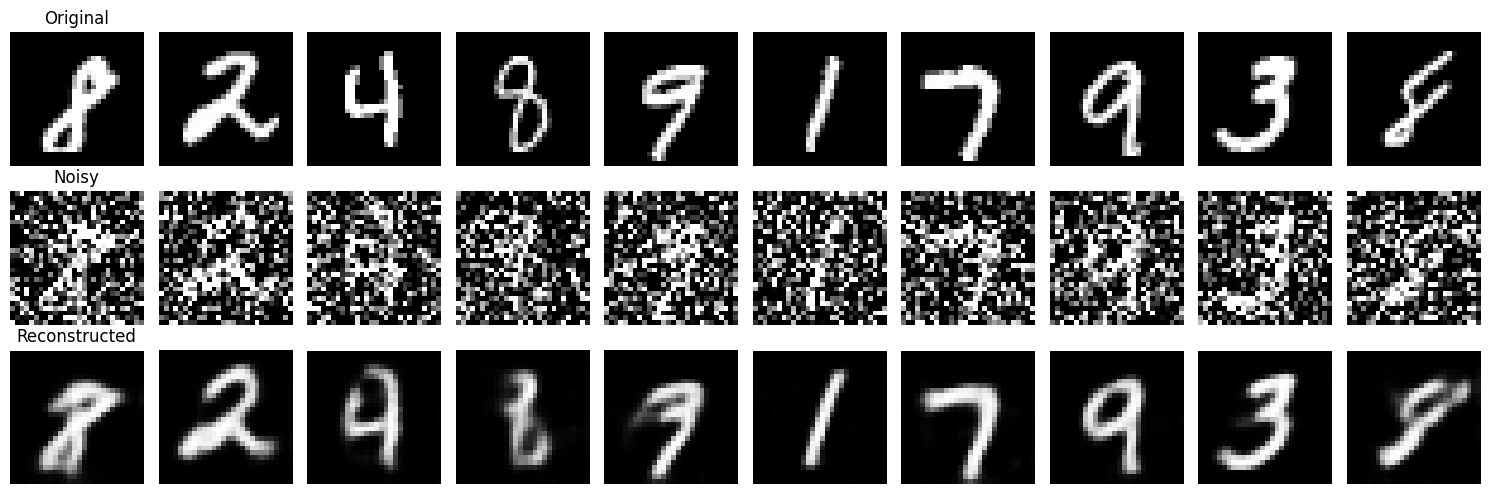

Epoch 5/10, Loss: 0.0186


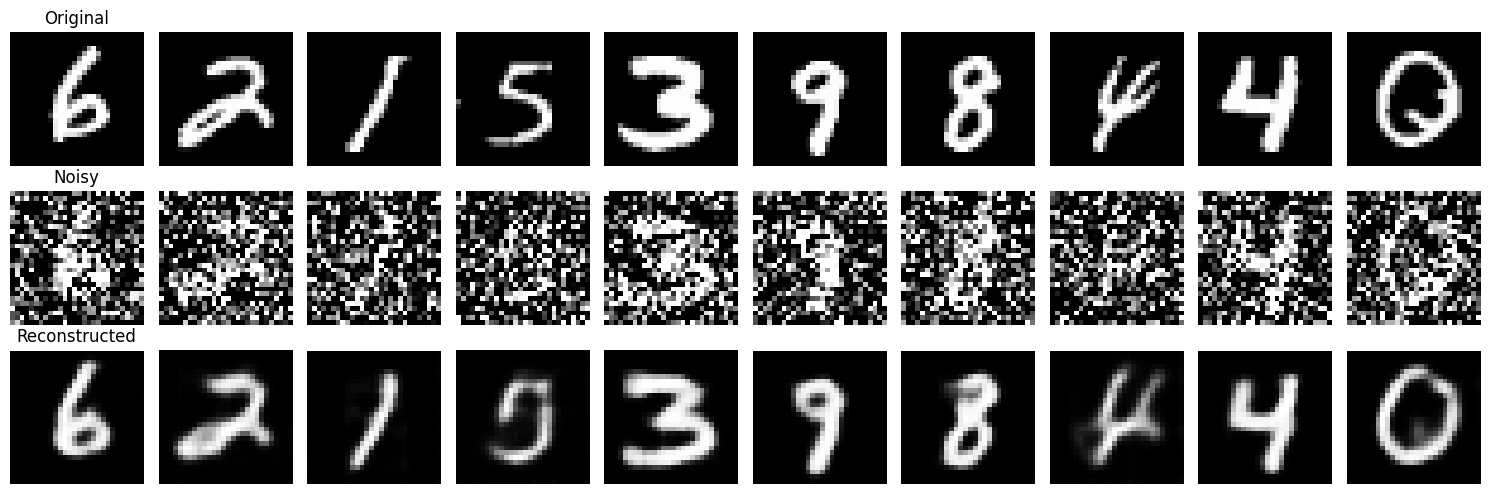

Epoch 6/10, Loss: 0.0182


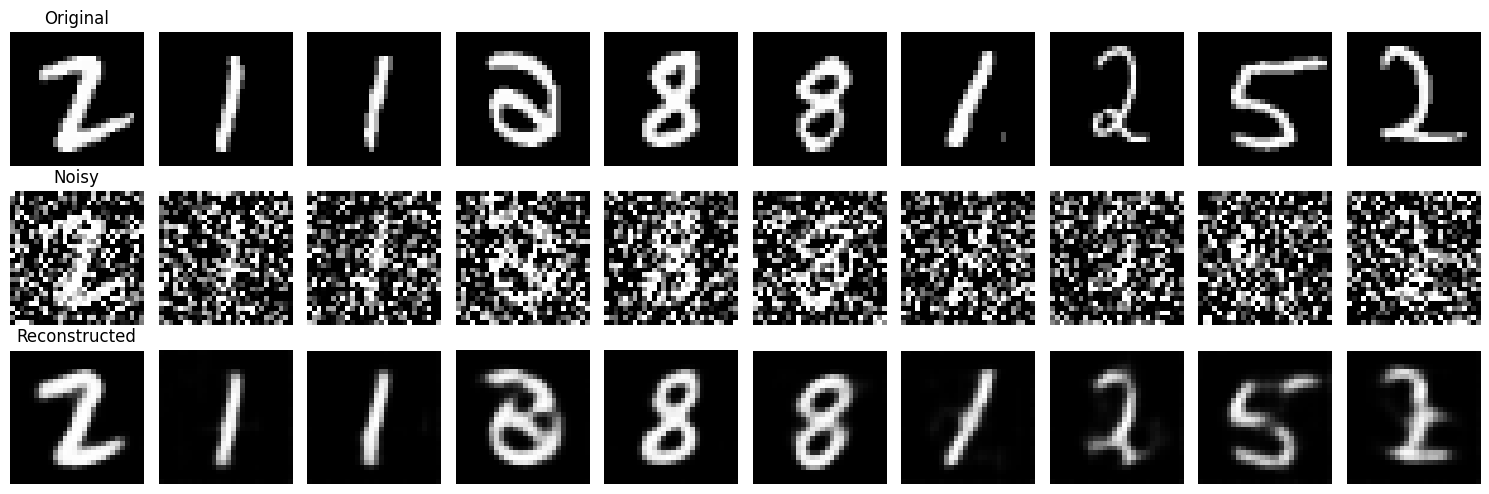

Epoch 7/10, Loss: 0.0180


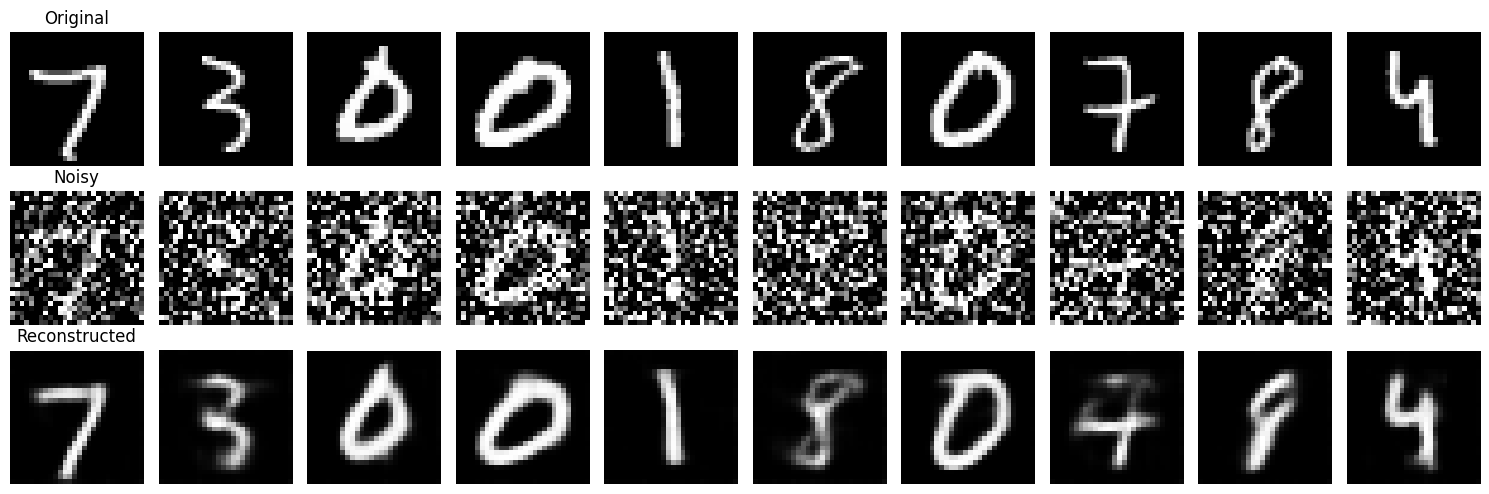

Epoch 8/10, Loss: 0.0178


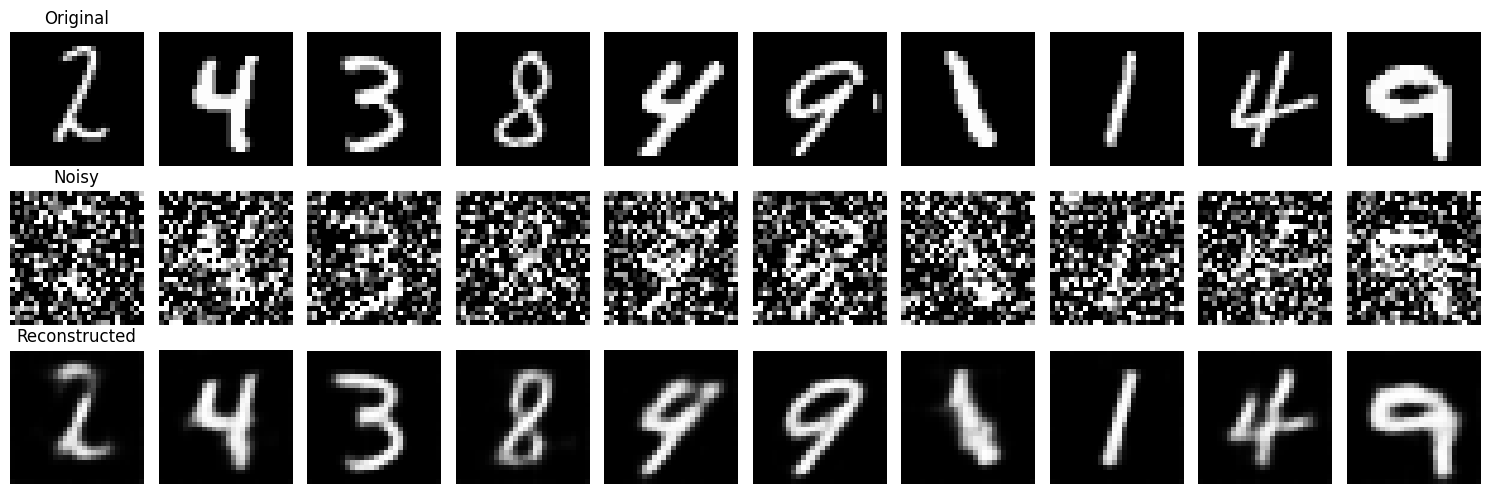

Epoch 9/10, Loss: 0.0177


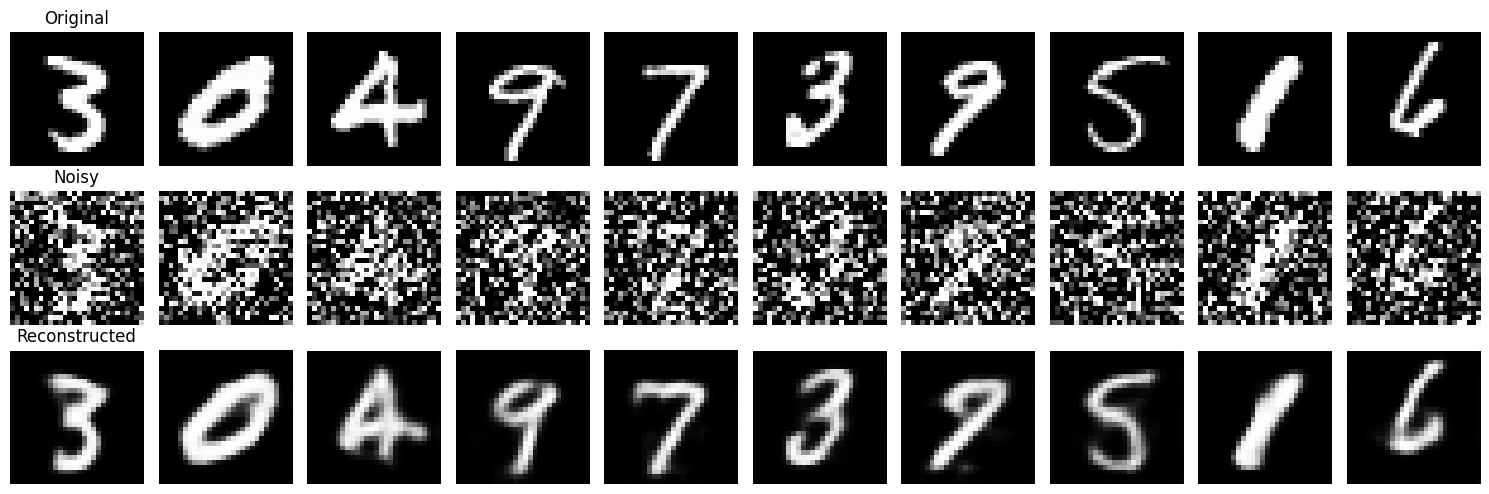

Epoch 10/10, Loss: 0.0176


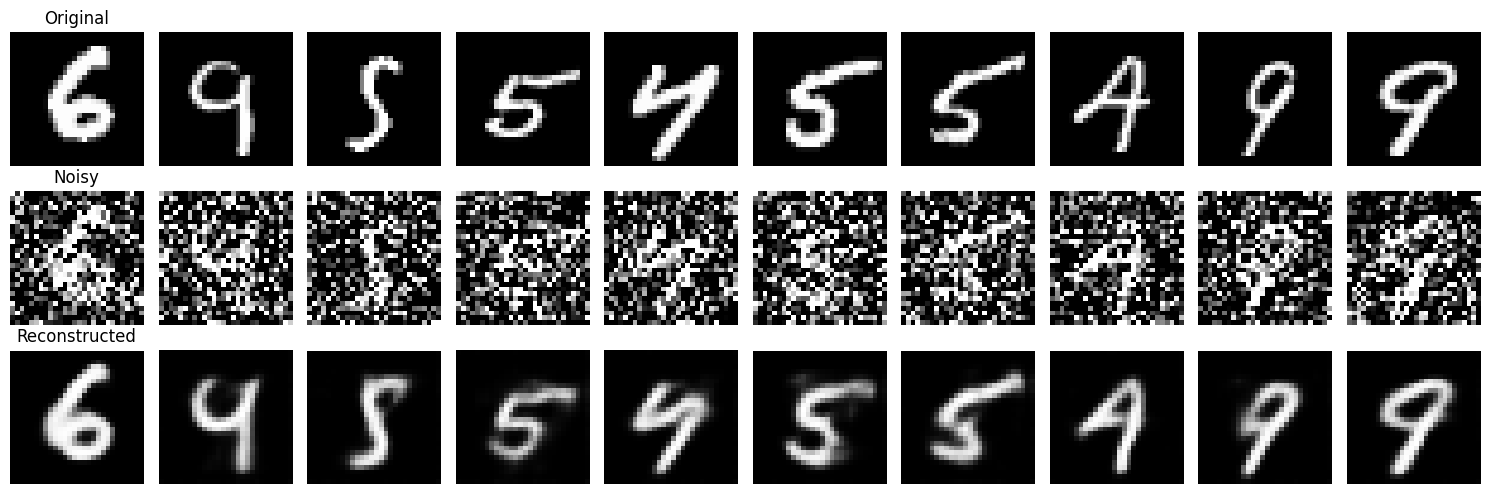

Training with lr=0.001, noise_factor=0.9, weight_decay=1e-05
Epoch 1/10, Loss: 0.0547


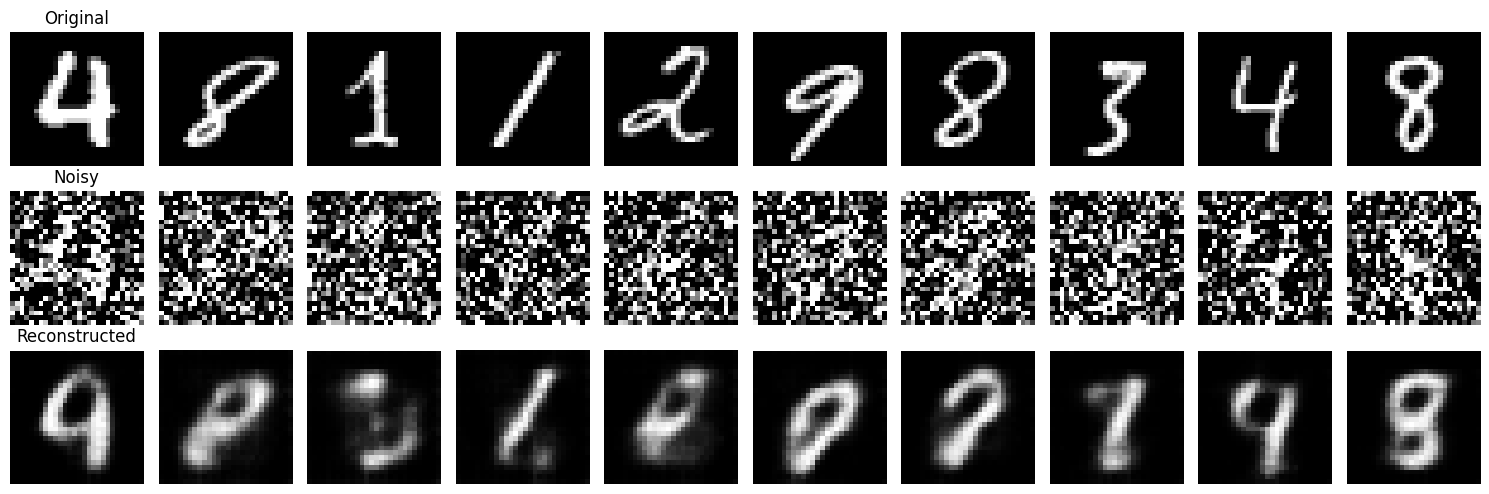

Epoch 2/10, Loss: 0.0309


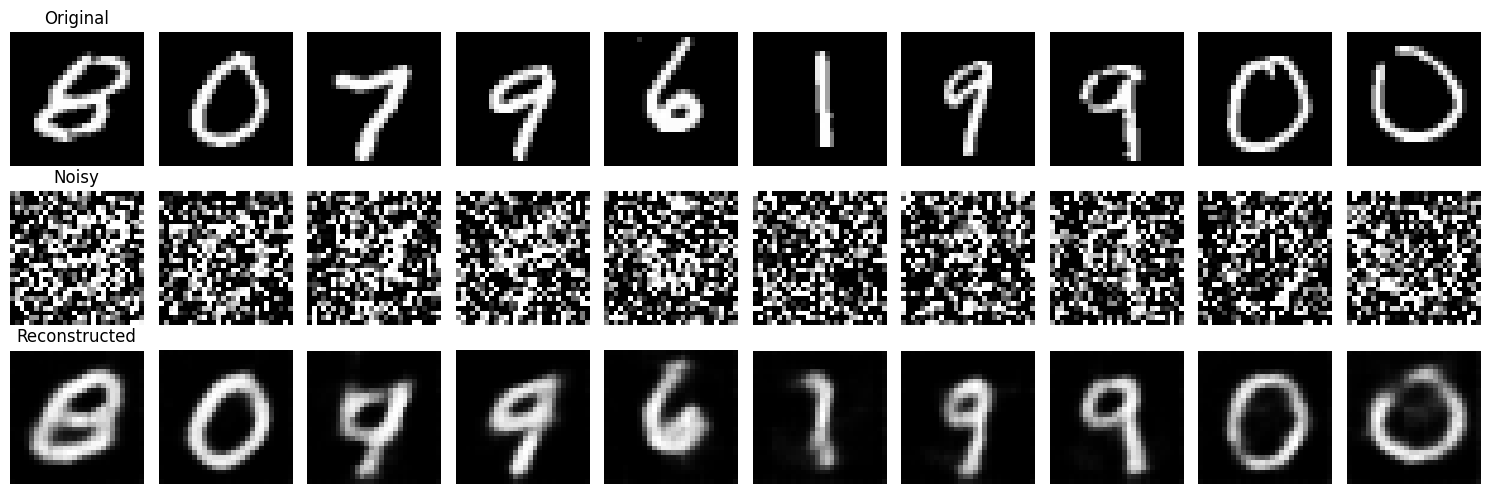

Epoch 3/10, Loss: 0.0277


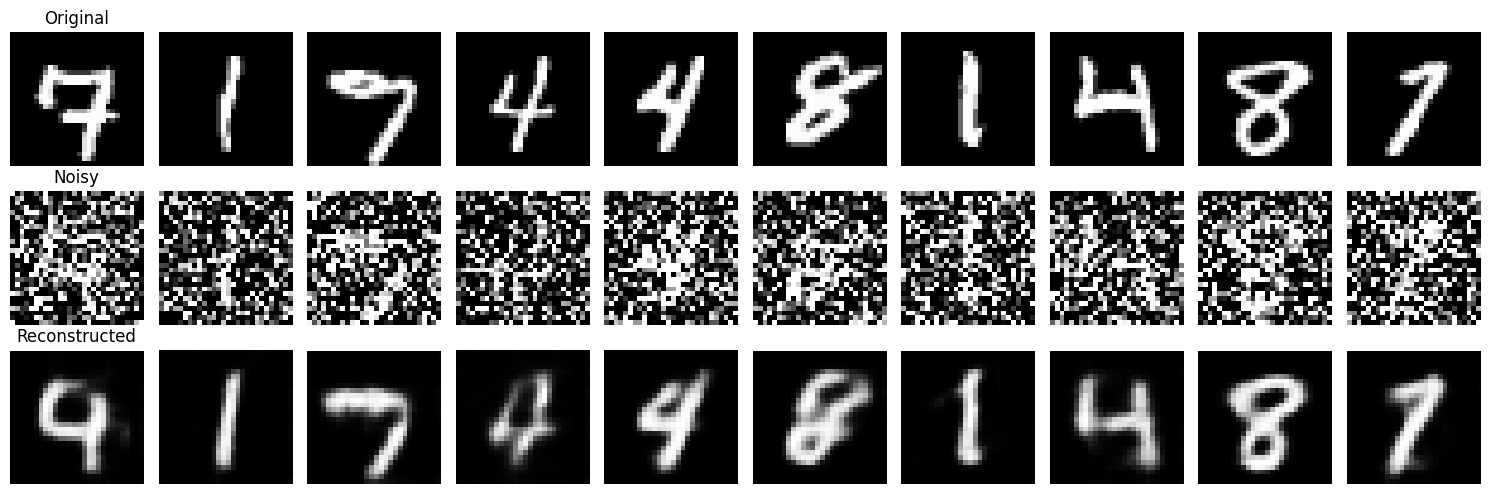

Epoch 4/10, Loss: 0.0264


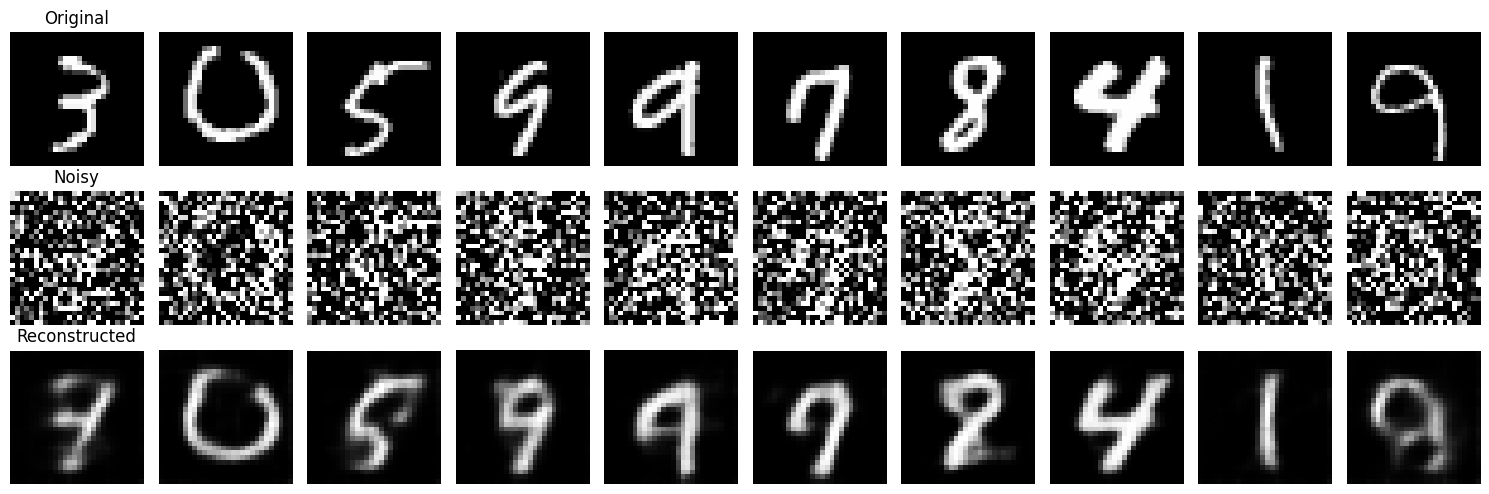

Epoch 5/10, Loss: 0.0257


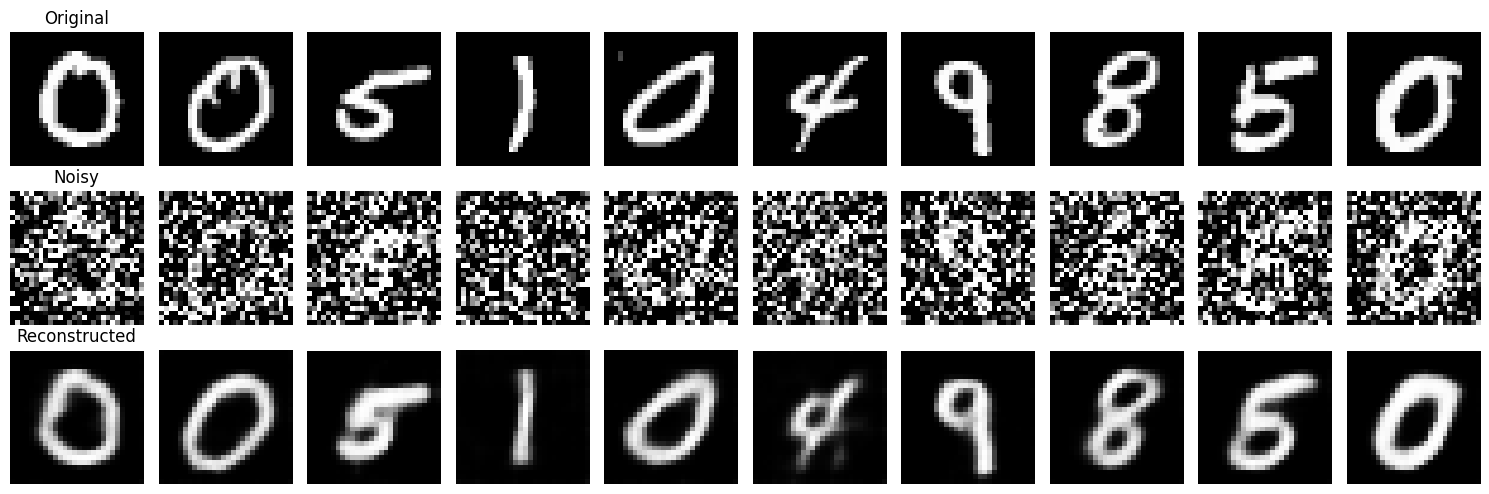

Epoch 6/10, Loss: 0.0253


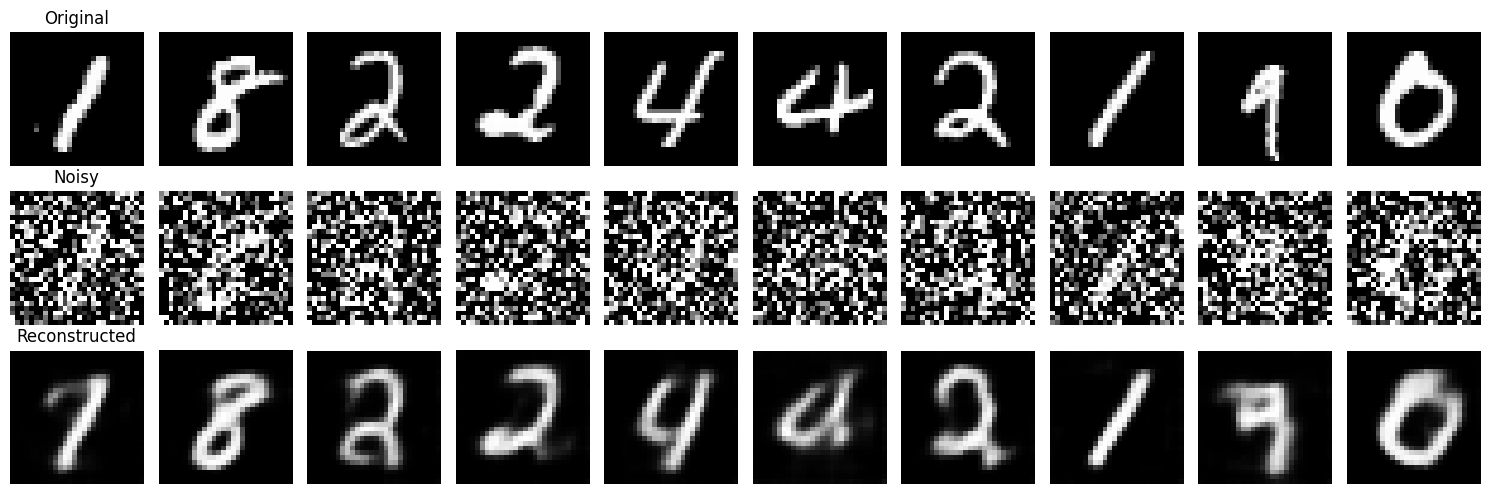

Epoch 7/10, Loss: 0.0250


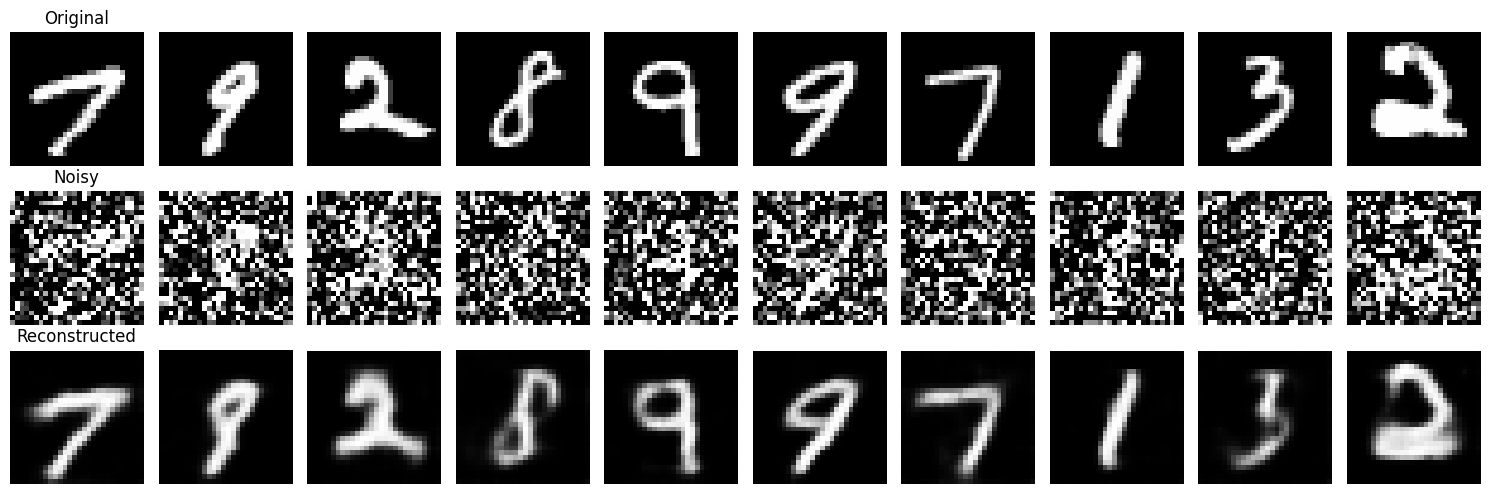

Epoch 8/10, Loss: 0.0248


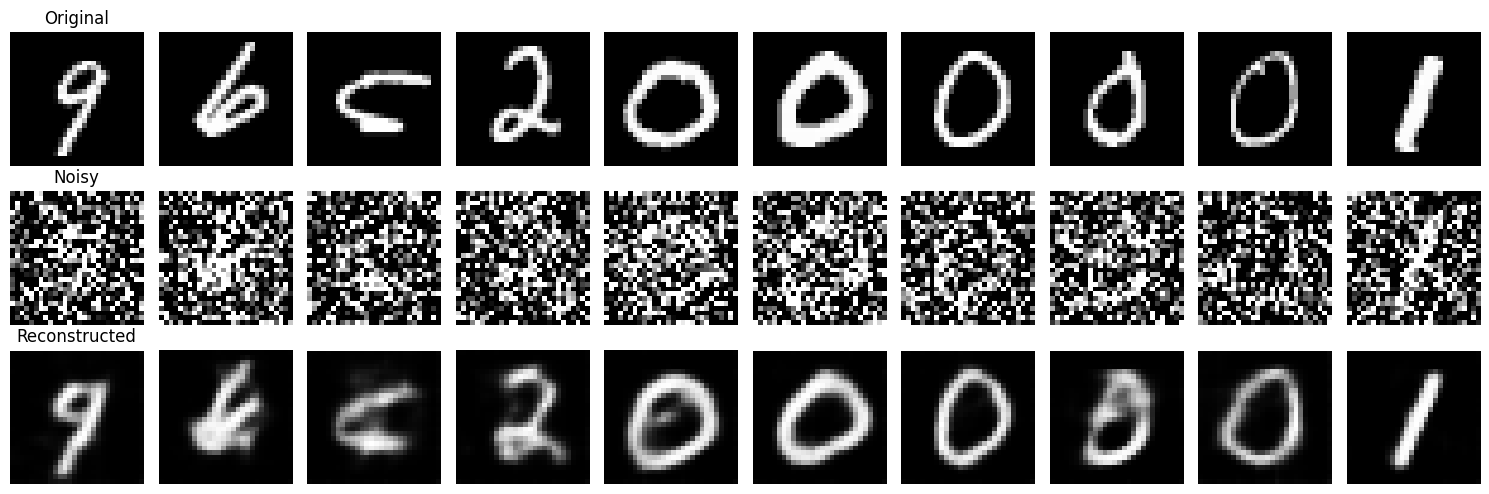

Epoch 9/10, Loss: 0.0246


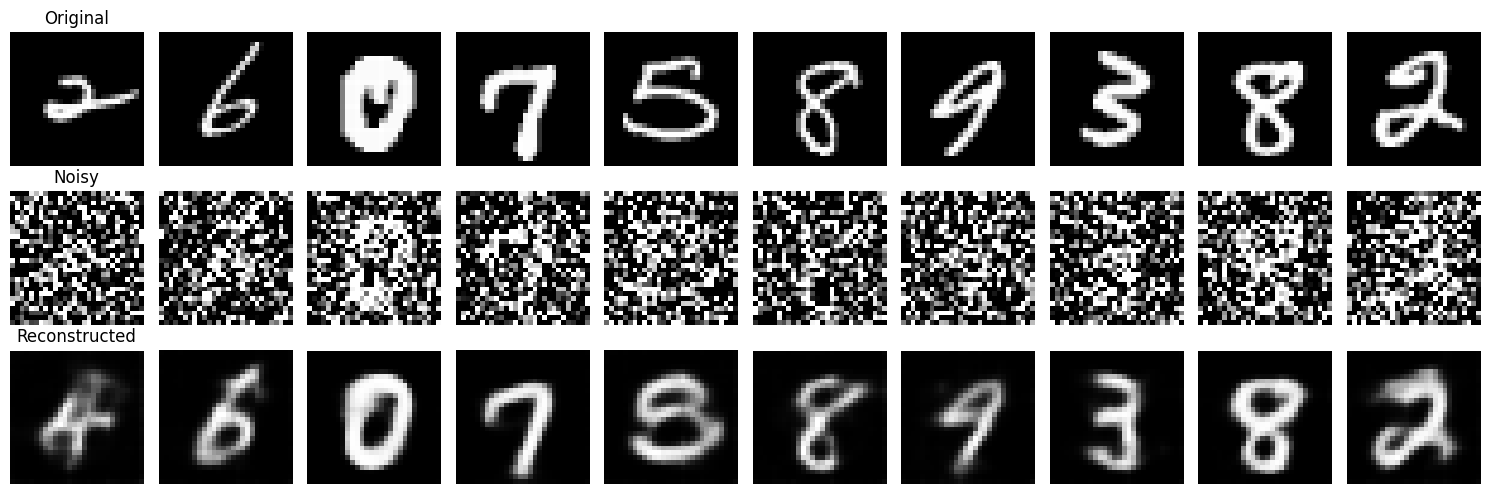

Epoch 10/10, Loss: 0.0245


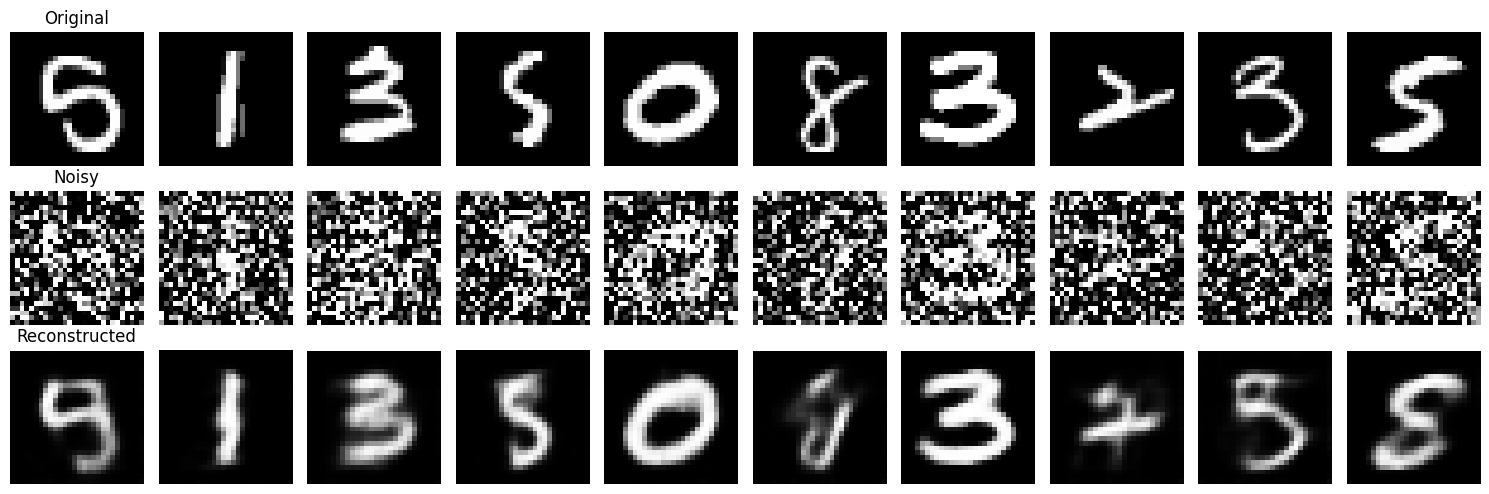

In [ ]:
model = Autoencoder().to(device)
#model = Autoencoder_Linear()

lr = 0.001
wd = 1e-5
for noise_factor in [0.5, 0.7, 0.9]:

  print(f"Training with lr={lr}, noise_factor={noise_factor}, weight_decay={wd}")

  # Crear modelo y moverlo a la GPU
  model = Autoencoder().to(device)
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

  # Entrenamiento
  for epoch in range(num_epochs):
      epoch_loss = 0
      for batch_idx, (img, _) in enumerate(data_loader):
          img = img.to(device)  # Mover imágenes a la GPU
          noisy_image = add_noise(img, noise_factor=noise_factor)  # Agregar ruido
          noisy_image = noisy_image.to(device)  # Asegurar que las imágenes ruidosas también estén en GPU

          recon = model(noisy_image)  # Reconstrucción
          loss = criterion(recon, img)  # Cálculo de la pérdida

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          epoch_loss += loss.item()

      epoch_loss /= len(data_loader)  # Promedio por batch
      print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

      # Visualización de imágenes después de cada época
      with torch.no_grad():
          # Tomar un batch para mostrar imágenes
          img, _ = next(iter(data_loader))
          img = img.to(device)
          noisy_image = add_noise(img, noise_factor=noise_factor).to(device)
          recon = model(noisy_image)

          # Mover datos a CPU para visualización
          img = img.cpu()
          noisy_image = noisy_image.cpu()
          recon = recon.cpu()

          # Mostrar imágenes
          fig, axes = plt.subplots(3, 10, figsize=(15, 5))
          for i in range(10):  # Mostrar las primeras 10 imágenes del batch
              # Imagen original
              axes[0, i].imshow(img[i].squeeze(), cmap='gray')
              axes[0, i].axis('off')
              if i == 0:
                  axes[0, i].set_title("Original")

              # Imagen con ruido
              axes[1, i].imshow(noisy_image[i].squeeze(), cmap='gray')
              axes[1, i].axis('off')
              if i == 0:
                  axes[1, i].set_title("Noisy")

              # Imagen reconstruida
              axes[2, i].imshow(recon[i].squeeze(), cmap='gray')
              axes[2, i].axis('off')
              if i == 0:
                  axes[2, i].set_title("Reconstructed")

          plt.tight_layout()
          plt.show()




## Resize

Epoch 1/10, Loss: 0.0354
Epoch 2/10, Loss: 0.0293
Epoch 3/10, Loss: 0.0284
Epoch 4/10, Loss: 0.0279
Epoch 5/10, Loss: 0.0275
Epoch 6/10, Loss: 0.0272
Epoch 7/10, Loss: 0.0270
Epoch 8/10, Loss: 0.0268
Epoch 9/10, Loss: 0.0266
Epoch 10/10, Loss: 0.0265


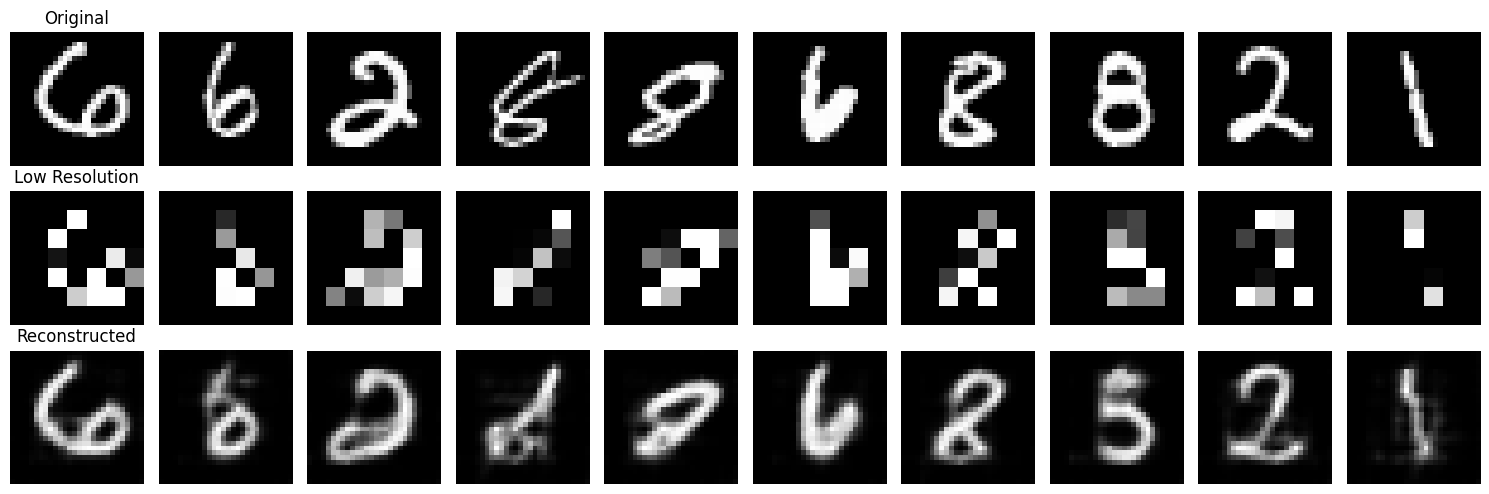

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Definir el modelo de Autoencoder
class SuperResolutionAutoencoder(nn.Module):
    def __init__(self):
        super(SuperResolutionAutoencoder, self).__init__()

        # Encoder (reduce la resolución)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),  # Imagen original (7x7, 14x14)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Codificación
            nn.ReLU()
        )

        # Decoder (aumenta la resolución a 28x28)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2, padding=1, output_padding=1),    # 14x14 -> 28x28
            nn.Sigmoid()  # Para valores entre 0 y 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# Entrenamiento
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SuperResolutionAutoencoder().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
num_epochs = 10

# Entrenamiento del modelo
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_idx, (img, _) in enumerate(data_loader):
        img = img.to(device)  # Imagen original 28x28

        # Crear una versión de baja resolución de la imagen original
        low_res_image = nn.functional.interpolate(img, size=(7, 7), mode='nearest')  # Simula baja resolución
        low_res_image = low_res_image.to(device)  # Baja resolución

        # Pasar la imagen de baja resolución al autoencoder
        recon = model(low_res_image)

        # Calcular la pérdida comparando con la imagen original
        loss = criterion(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(data_loader)  # Promedio por batch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Visualización final
with torch.no_grad():
    img, _ = next(iter(data_loader))
    img = img.to(device)

    # Crear una versión de baja resolución
    low_res_image = nn.functional.interpolate(img, size=(7, 7), mode='nearest')
    low_res_image = low_res_image.to(device)

    # Reconstruir la imagen de alta resolución
    recon = model(low_res_image)

    # Mover datos a CPU para visualización
    img = img.cpu()
    low_res_image = low_res_image.cpu()
    recon = recon.cpu()

    # Mostrar imágenes
    fig, axes = plt.subplots(3, 10, figsize=(15, 5))
    for i in range(10):  # Mostrar las primeras 10 imágenes del batch
        # Imagen original
        axes[0, i].imshow(img[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title("Original")

        # Imagen de baja resolución
        axes[1, i].imshow(low_res_image[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title("Low Resolution")

        # Imagen reconstruida
        axes[2, i].imshow(recon[i].squeeze(), cmap='gray')
        axes[2, i].axis('off')
        if i == 0:
            axes[2, i].set_title("Reconstructed")

    plt.tight_layout()
    plt.show()
